In [1]:
from containers.cities import CitiesGraph

path = "data/cities.csv"
graph = CitiesGraph.from_file(path, [
    "Dallas",
    "Detroit",
    "Los Angeles",
    "Miami",
    "New York City",
    "Oklahoma City",
    "San Francisco",
])
graph.coords

,city,x,y
0,San Francisco,-2440.234574,-4226.610264
1,Los Angeles,-2609.408837,-4519.628684
2,Oklahoma City,-906.238179,-5139.532107
3,Dallas,-454.849931,-5198.958497
4,Detroit,425.360913,-4861.897489
5,Miami,1002.659670,-5686.365557
6,New York City,1263.158364,-4714.171194


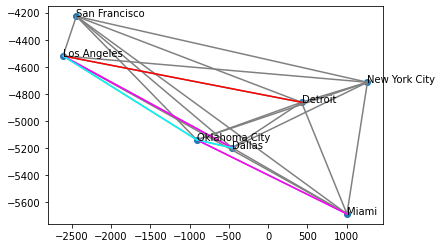

In [2]:
graph.fully_connect()
graph.plot_points()
graph.plot_connections(color="grey")
graph.plot_segment(1, 4, color='r')
graph.plot_segments([(1, 3), (2, 5)], color='magenta')
graph.plot_line([1, 2, 3], color='cyan')

In [3]:
graph.get_detailed_connections()

[(3, 4, 942.5397889475429),
 (4, 6, 850.7218269469794),
 (0, 2, 1785.0969809517521),
 (0, 5, 3739.5730085606915),
 (1, 6, 3877.450646688036),
 (2, 5, 1985.6781757702372),
 (1, 3, 2259.1177652193123),
 (4, 5, 1006.4896668721642),
 (5, 6, 1006.4896668721631),
 (3, 6, 1785.0969809517533),
 (0, 1, 338.34852705415807),
 (2, 4, 1360.234216473583),
 (1, 2, 1812.4763573894973),
 (0, 4, 2935.170753675907),
 (1, 5, 3795.828477396126),
 (3, 5, 1536.8473824864882),
 (0, 3, 2210.704246954231),
 (1, 4, 3054.00972064112),
 (0, 6, 3735.349369536725),
 (2, 3, 455.2832594369441),
 (2, 6, 2210.704246954232)]